# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [42]:
import os

In [43]:
import gymnasium as gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()

In [44]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [45]:
policy = np.ones((n_states, n_actions)) / n_actions
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [46]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()[0]
    
    
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])
        
        new_s,r,done, truncated, info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)  # add state
        actions.append(a) # add action
        total_reward += r # add reward
        
        s = new_s
        if done:
            break
    return states,actions,total_reward

In [47]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]

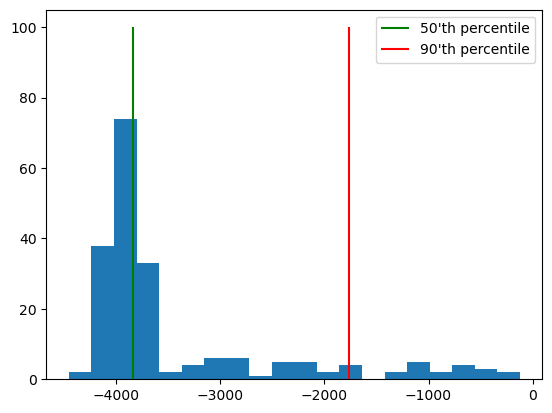

In [48]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()
plt.show()

### Crossentropy method steps (1pts)

In [49]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = []
    elite_actions = []
    
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions

In [50]:
states_batch = np.array([
    np.array([1,2,3]),   #game1
    np.array([4,2,0,2]), #game2
    np.array([3,1])      #game3
], dtype=object)

actions_batch = np.array([
    np.array([0,2,4]),   #game1
    np.array([3,2,0,1]), #game2
    np.array([3,3])      #game3
], dtype=object)
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [51]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states, n_actions])
    
    
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1
    
    for state in range(n_states):
        state_visit_count = np.sum(new_policy[state])
        if state_visit_count > 0:
            new_policy[state] /= state_visit_count
        else:
            new_policy[state] = 1.0 / n_actions
    
    return new_policy

In [52]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [53]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [54]:
policy = np.ones((n_states, n_actions)) / n_actions


mean reward = -910.472, threshold=8.000


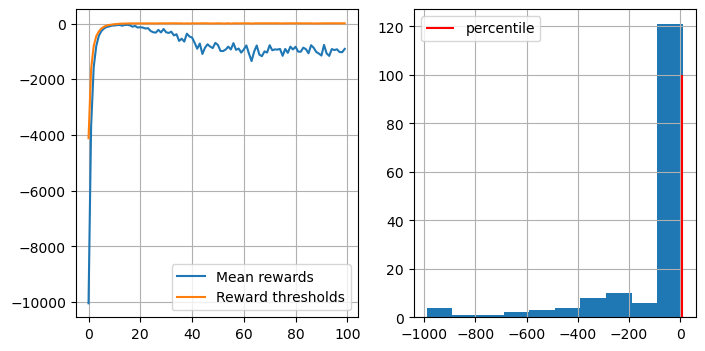

In [17]:
n_sessions = 250 
percentile = 70  
learning_rate = 0.5  

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)
    

    elite_states, elite_actions = select_elites(np.array(states_batch, dtype=object),np.array(actions_batch, dtype=object),np.array(rewards_batch, dtype=object),percentile=70)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    
    
    show_progress(rewards_batch,log)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [55]:
import gymnasium as gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 150



In [71]:
#сравнение разных percentiles
import gymnasium as gym
import numpy as np, pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline





env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n


policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)


s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]


stepCounter = 40
n_sessions = 250  
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
learning_rate = 0.5




results = {}

for percentile in percentiles:
    print(str(percentile)+'%')
    
    policy = np.ones([n_states, n_actions]) / n_actions
    log = []
    mean_r\ewards = []
    
    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        
        elite_states, elite_actions = select_elites(np.array(states_batch, dtype=object), np.array(actions_batch, dtype=object), 
            np.array(rewards_batch), percentile=percentile)
        
        new_policy = update_policy(elite_states, elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        
        
        mean_rewards.append(np.mean(rewards_batch))
        
        clear_output(True)
    
    results[percentile] = mean_rewards


plt.figure(figsize=(12, 8))
for percentile, rewards in results.items():
    plt.plot(rewards, label=f'Percentile {percentile}')

plt.xlabel('Training Step')
plt.ylabel('Mean Reward')
plt.title('Different Percentiles')
plt.legend()
plt.grid(True)
plt.show()

for percentile, rewards in results.items():
    
    print('Persentile ' + str(percentile) + ': ' +str(rewards[-1])) 


env.close()

10%


KeyboardInterrupt: 

# How do different percentiles affect training efficiency?

Чем ниже процент, тем быстрее стремится график к 0. Лучший результат достгнут при 30%. 70%, 80%, 90% сильно отклонились от остальных.

In [20]:
#сранвение разных n_samples
import gymnasium as gym
import numpy as np, pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n


policy = np.ones([n_states, n_actions]) / n_actions
stepCounter = 40

n_sessions_ar = [100, 200, 500, 1000] 
percentile = 70 
learning_rate = 0.5


results = {}

plt.figure(figsize=(12, 8))

for n_sessions in n_sessions_ar:
    print(n_sessions)
    
    policy = np.ones([n_states, n_actions]) / n_actions
    log = []
    mean_rewards_per_iteration = []
    
    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        
        elite_states, elite_actions = select_elites(np.array(states_batch, dtype=object), np.array(actions_batch, dtype=object),
            np.array(rewards_batch), percentile=percentile
        )
        
        new_policy = update_policy(elite_states, elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        
        
        mean_reward = np.mean(rewards_batch)
        mean_rewards_per_iteration.append(mean_reward)
        
    
    
    results[n_sessions] = mean_rewards_per_iteration
    
    
    plt.plot(range(stepCounter), mean_rewards_per_iteration, label=f'n_sessions={n_sessions}')

plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.title('Different n_samples')
plt.legend()
plt.tight_layout()
plt.show()




100



KeyboardInterrupt



In [ ]:
#алгоритм с позитивным результатом
import gymnasium as gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 150


n_sessions = 800  #sample this many sessions
percentile = 25  #take this percent of session with highest rewards
learning_rate = 0.8  #add this thing to all counts for stability

log = []

for i in range(150):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)
    

    elite_states, elite_actions = select_elites(np.array(states_batch, dtype=object),np.array(actions_batch, dtype=object),np.array(rewards_batch, dtype=object),percentile=25)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    
    
    show_progress(rewards_batch,log)

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [36]:
def generate_session(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.
    
    s = env.reset()[0]
    
    for t in range(t_max):
        
        action_probs = policy[s]
        action = np.random.choice(n_actions, p=action_probs)
        
        next_s, reward, done, tunc, info = env.step(action)
        
        states.append(s)
        actions.append(action)
        total_reward += reward
        
        s = next_s
        
        if done:
            break
            
    return states, actions, total_reward

Iteration 0, Mean reward: -9630.799
Iteration 10, Mean reward: -4490.083
Iteration 20, Mean reward: -1934.629
Iteration 30, Mean reward: -915.064
Iteration 40, Mean reward: -591.939
Iteration 50, Mean reward: -334.876


<Figure size 1200x800 with 0 Axes>

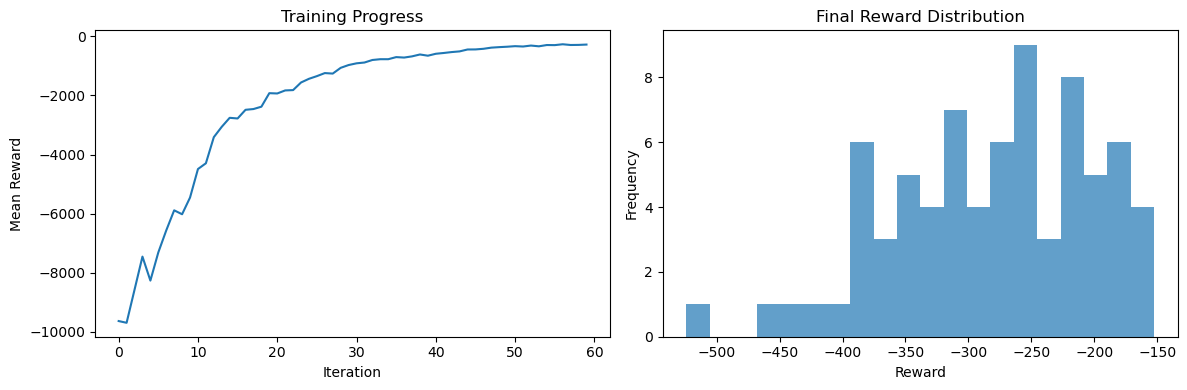

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax


def stabilized_generate_session(policy, t_max=10**4, n_avg=10):
    total_rewards = []
    
    for _ in range(n_avg):
        _, _, reward = generate_session(policy, t_max)
        total_rewards.append(reward)
    
    
    median_idx = np.argsort(total_rewards)[len(total_rewards) // 2]
    
    
    for i in range(n_avg):
        states, actions, reward = generate_session(policy, t_max)
        if i == median_idx:
            return states, actions, np.mean(total_rewards)
    
    return states, actions, np.mean(total_rewards)


n_sessions = 75
percentile = 25
learning_rate = 0.8
stabilization_window = 10

log = []
policy_log = []
policy = np.ones([n_states, n_actions]) / n_actions

for i in range(1000):
    
    sessions = [stabilized_generate_session(policy) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    elite_states, elite_actions = select_elites(np.array(states_batch, dtype=object), np.array(actions_batch, dtype=object), 
        np.array(rewards_batch), percentile=percentile)

    new_policy = update_policy(elite_states, elite_actions)
    
    state_visits = new_policy.sum(axis=1, keepdims=True)
    state_visits = np.maximum(state_visits, 1e-8)
    
    new_policy = new_policy / state_visits
    updated_policy = (1 - learning_rate) * policy + learning_rate * new_policy
    
    
    updated_policy = softmax(np.log(np.maximum(updated_policy, 1e-8)), axis=1)
    
    
    policy_log.append(new_policy)
    if len(policy_log) > stabilization_window:
        policy_log.pop(0)
    
    
    policy = np.mean(policy_log, axis=0)
    
    
    policy = policy / policy.sum(axis=1, keepdims=True)
    
    log.append(np.mean(rewards_batch))
    
   
    if i % 10 == 0:
        print(i)
    
    if np.mean(rewards_batch) > 7:
        print("Win! Target reward achieved!")
        break


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(log)
plt.title('Training Progress')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')


plt.tight_layout()
plt.show()

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

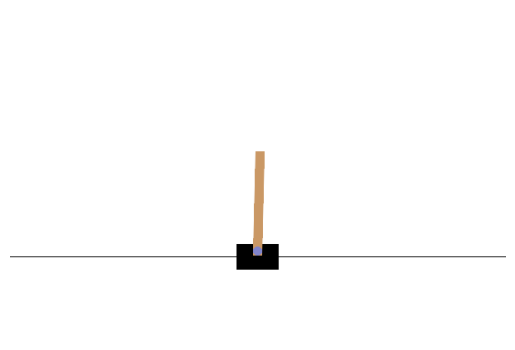

In [19]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


env = gym.make("CartPole-v1", render_mode='rgb_array')

observation, info = env.reset()
n_actions = env.action_space.n


frame = env.render()
plt.imshow(frame)
plt.axis('off') 
plt.show()



In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [20]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
initial_state, info = env.reset()
agent.fit([initial_state] * n_actions, list(range(n_actions)))


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20), max_iter=1,
              warm_start=True)

In [21]:
def generate_session(t_max=1000):
    states, actions = [], []
    total_reward = 0
    
    s = env.reset()[0]
    
    for t in range(t_max):
        
        probs = agent.predict_proba([s])[0]
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s, r, done, truncated, info = env.step(a)
        
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done or truncated: 
            break
    return states, actions, total_reward

In [22]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = []
    elite_actions = []
    
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions

To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

mean reward = 221.670, threshold=274.000


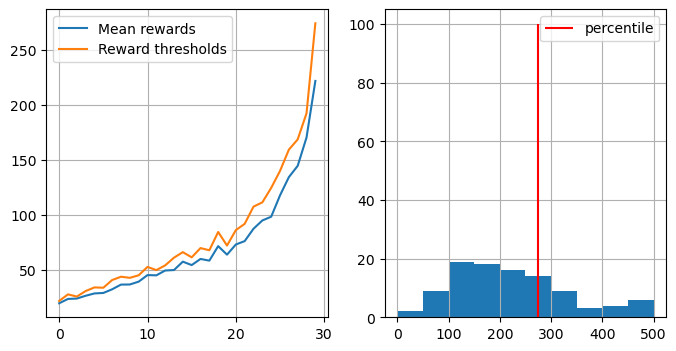

You Win! You may stop training now via KeyboardInterrupt.


In [23]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions), (list, list, list))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    
   
    agent.fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])
    
    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break


env.close()

# Report (1 pts)

In [ ]:
# Describe what you did here.  Preferably with plot/report to support it